# Inference

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

现在考虑一个简单的模型：

$$
weight|guess \sim Normal(guess, 1) \\
measurement|guess, weight \sim Normal(weight, 0.75)
$$

这是一个关于物体重量的模型，其随机性来自于两个方面：

1. 是这个物体本身的随机性，即这个物体可能是2kg，也可能是3kg，我们先验的认为是guess kg，则真实的weight是以此为均值的正态分布。
2. 是测量的随机性，即相同的物体在不同时刻测量有不同的measurement，这个也被认为是一个正态随机噪声。

In [3]:
# 使用pyro模型表示

def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))
for _ in range(5):
    print(scale(10))

tensor(7.9981)
tensor(10.2329)
tensor(8.6991)
tensor(9.4201)
tensor(7.0255)


## Conditioning

现在对于我们进行推断的第一步，需要将观察的数据放入model中，即对其中的某个变量进行限制，然后才能进行推断。比如现在我们观察到我们的测量结果是9.5，然后我们希望去推断真实的weight是多少？

单纯限制其中某些变量、提供观察数据的工作由下面的几种方式来完成：

第一，使用`pyro.condition`函数，其接受一个model和观测，然后返回一个新的model（这个model接受的输入和之前的model一致）。注意，其只是做到了把观测放入模型，还没有求出后验分布。

In [5]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)
deferred_conditioned_scale(9.5, 10)

9.5

In [6]:
# 其返回的就是9.5，因为原始的model输出的是measurement的值，现在你固定了measurement的值，则其只会返回这个值。
deferred_conditioned_scale(9.5, 5)

9.5

第二，使用`pyro.sample`中的`obs`参数，其效果和`condition`一致（使用的更多）

In [7]:
def scale_obs(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=9.5)
scale_obs(10)

9.5

最后一种方式，是使用`pyro.do`，来自因果推断的语言。

## 使用guide进行近似估计

我们现在希望求解`meansurement=9.5`以及已知先验分布`guess`下`weight`的分布。

我们的方法是SVI，即使用一个分布去近似它，这个分布就是`guide`。

guide函数有以下两个要求：

1. 所有在model中出现过的、unobserved（not conditional，即没有使用`obs`参数来固定观测数据）的随机变量都必须在guide中出现（name必须一样）；
2. 其输入必须和model一致。

注意到，guide函数在不同的inference算法中可能有不同的含义（比如MCMC中可能就是提议分布了），但在SVI中，其表示的就是那个可以进行梯度下降更新、然后去用于拟合后验分布的`Q(z)`。其必须足够灵活，便于能够拟合不同形式的分布。

以上这个模型是简单的，我们可以直接指导真实的后验分布就是：$Normal(9.14, 0.6)$

In [8]:
def perfect_guide(guess):
    loc = (0.75 ** 2 * guess + 9.5) / (1 + 0.75 ** 2)  # 9.14
    scale = np.sqrt(0.75 **2 / (1 + 0.75 ** 2))  # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))
perfect_guide(3.0)

tensor(7.0300)

但当我们处理更加负责的模型的时候，我们就无法直接推导出这样的结果了。比如我们很难推导出后验分布具体是beta分布还是gamma分布，甚至其无法显式的写出。就算我们能够知道其具体是什么分布，而分布的参数也是难以计算的。

所以，我们退一步，我们使用一个具有一定灵活性的分布Q(z)去近似它，并且给与这个分布的参数一个范围而不是确定的一个值，我们利用算法去找这个范围内哪个值使得这个Q(z)最像后验分布。

这时指定参数范围时需要使用`pyro.param`。其工作原理类似于`dict`，首先`pyro`会创建一个`param_store`空间，然后会使用key-value的方式将创建的param都储存到其中。`pyro.param`即可以用来赋值添加到空间中，也可以用于从空间中取出某个参数。其中value除了储存现在的值(初始值)，还包括其拟合范围等等。

In [10]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))
scale_parametrized_guide(3.0)

tensor(2.2738, grad_fn=<AddBackward0>)

In [11]:
pyro.param("a")

tensor(3., requires_grad=True)

In [12]:
pyro.param("b")

tensor(1., requires_grad=True)

以上的代码中我们看到，我们必须将std限制到正数范围内，这使用`torch.abs`来完成。但在很多的分布中都会有这样的限制，`pyro`提供了一个`constraints`模块来直接提供这样的限制。

In [13]:
from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))
scale_parametrized_guide(3.0)

tensor(4.8464, grad_fn=<AddBackward0>)

现在我们使用SVI来更新param，这个algorithm有以下3个characteristics：

1. 其params必须是real values；
2. 使用Monte Carlo估计来计算loss和gradient；
3. 使用stochastic gredient descent来进行参数更新；

In [16]:
guess = 8.5

pyro.clear_param_store()  # 清空params_store空间
svi = pyro.infer.SVI(
    scale_obs, scale_parametrized_guide_constrained,
    pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
    loss=pyro.infer.Trace_ELBO()
)

a =  9.109820365905762
b =  0.6095685362815857


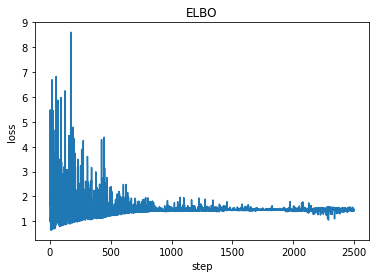

In [17]:
losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print("a = ", pyro.param("a").item())
print("b = ", pyro.param("b").item())

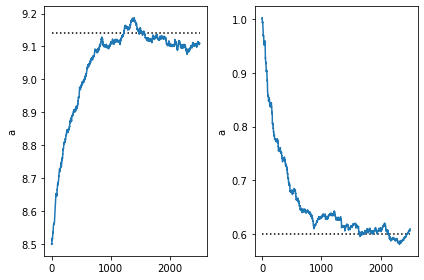

In [18]:
plt.subplot(1, 2, 1)
plt.plot([0, num_steps], [9.14, 9.14], "k:")
plt.plot(a)
plt.ylabel("a")

plt.subplot(1, 2, 2)
plt.ylabel("a")
plt.plot([0, num_steps], [0.6, 0.6], "k:")
plt.plot(b)
plt.tight_layout()

现在guide就可以看做是我们估计得到的后验分布，我们可以利用它来进行后验分布采样、估计等等。